# Pumped Catchment eDNA metabarcoding data processing

I will use [metaBEAT](https://github.com/HullUni-bioinformatics/metaBEAT), a tool tailored towards reproducible and efficient analyses of metabarcoding data that was developed by Dr. Christoph Hahn (University of Graz) for the EvoHull group at University of Hull. The pipeline is still under active development and will likely be extended further in the future. The pipeline is available in a Docker container with all necessary dependencies. The Docker image builds on [ReproPhylo](https://github.com/HullUni-bioinformatics/ReproPhylo).

The metaBEAT tool is designed for complete bioinformatic analysis from raw data, and performs (optionally) de-multiplexing, quality filtering, chimera detection, clustering, and taxononomic assignment (outputs in `.biom` and `.tsv` formats). It currently supports BLAST, Kraken and phylogenetic placement (pplacer).

# Data input

This notebook will perform basic processing (trimming, merging, chimera removal, clustering and taxonomic assignment) of the metabarcoding data.

Minimum input for an analysis is a set of query sequences in one or several files (a number of file formats are accepted, e.g. `.fasta`, `.fastq`). These will be run through the pipeline sequentially.

Information on the nature and location of the query sequence files must be provided in a separate tab-delimited text file via the -Q flags.

Each line in this text file should look as follows: unique sample_ID, format, file1, file2

The required text files can be generated in any text editor. So theoretically, nano could be used in the terminal to construct the text file. For reproducibility and ease, a simple program can be used to generate the required file.

In the cell below, it is produced using a simple python script. The script will list all files in the location to which you downloaded your Illumina data (specified via the 'datadir' variable). It assumes that there is a file ending in `_R1.fastq` for each sample. For each such file, it will extract the sample name from the filename and format the required line for the text file accordingly. The resulting file is called `Querymap.txt` (specified in the 'to' variable).

In [78]:
!pwd

/home/working/1-trimming


In [63]:
!mkdir 1-trimming

mkdir: cannot create directory ‘1-trimming’: File exists


In [64]:
cd 1-trimming

/home/working/1-trimming


In [79]:
!ls -1 ../raw_reads/

24-blank.R1.fastq.gz
24-blank.R2.fastq.gz
24-S1.R1.fastq.gz
24-S1.R2.fastq.gz
24-S2.R1.fastq.gz
24-S2.R2.fastq.gz
24-S3.R1.fastq.gz
24-S3.R2.fastq.gz
24-S4.R1.fastq.gz
24-S4.R2.fastq.gz
24-S5.R1.fastq.gz
24-S5.R2.fastq.gz
25-blank.R1.fastq.gz
25-blank.R2.fastq.gz
25-S1.R1.fastq.gz
25-S1.R2.fastq.gz
25-S2.R1.fastq.gz
25-S2.R2.fastq.gz
25-S3.R1.fastq.gz
25-S3.R2.fastq.gz
25-S4.R1.fastq.gz
25-S4.R2.fastq.gz
25-S5.R1.fastq.gz
25-S5.R2.fastq.gz
26-blank.R1.fastq.gz
26-blank.R2.fastq.gz
26-S1.R1.fastq.gz
26-S1.R2.fastq.gz
26-S2.R1.fastq.gz
26-S2.R2.fastq.gz
26-S3.R1.fastq.gz
26-S3.R2.fastq.gz
26-S4.R1.fastq.gz
26-S4.R2.fastq.gz
26-S5.R1.fastq.gz
26-S5.R2.fastq.gz
BL3-blank.R1.fastq.gz
BL3-blank.R2.fastq.gz
BL3-S1.R1.fastq.gz
BL3-S1.R2.fastq.gz
BL3-S2.R1.fastq.gz
BL3-S2.R2.fastq.gz
BL3-S3.R1.fastq.gz
BL3-S3.R2.fastq.gz
BL3-S4.R1.fastq.gz
BL3-S4.R2.fastq.gz
BL3-S5.R1.fastq.gz
BL3-S5.R2.fastq.gz
BL4-blank.R1.fastq.gz
BL4-blank.R2.fastq.gz
BL4-S1.R1.fastq.gz
BL4-S1.R2.fastq.gz
BL4-S2.R1.fastq.gz

Prepare a text file specifying the samples to be processed, including the format and location of the reads - the querymap.

The next command expects two `.fastq` files (forward and reverse reads) per sample in the directory `../raw_reads/`. It expects the files to be named 'SampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively.

The raw data have been downloaded and demultiplexed. They can be found in `../raw_reads/`.

SampleID must correspond to the first column in a file called `Sample_accessions.tsv`. This will either be pre-made to correspond to downloading read data from the NCBI Sequence Read Archive, or you will have to make it. The marker is '12S'.

If the `Sample_accessions.tsv` was pre-made, use this code to proceed:

In [42]:
#%%bash
#
#for a in $(cat ../Data/Sample_accessions.tsv | grep "12S" | cut -f 1 | grep "SampleID" -v)
#do
#    R1=$(ls -1 ../raw_reads/$a-12S_* | grep "_R1.fastq")
#    R2=$(ls -1 ../raw_reads/$a-12S_* | grep "_R2.fastq")
#
#    echo -e "$a\tfastq\t$R1\t$R2"
#done > Querymap.txt

cat: ../Data/Sample_accessions.tsv: No such file or directory


In [37]:
!head -n 10 Querymap.txt

**OR...**

To make the `Sample_accessions.tsv` file, use:

In [80]:
!echo "SampleID" > ../1-trimming/Sample_accessions.tsv

In [81]:
%%bash
for a in $(ls ../raw_reads/ | grep -w "R1" | cut -d '.' -f 1)
do 
   SampleID=$a
   
   echo -e "$SampleID"
done >> ../1-trimming/Sample_accessions.tsv

In [82]:
!cat ../1-trimming/Sample_accessions.tsv

SampleID
24-blank
24-S1
24-S2
24-S3
24-S4
24-S5
25-blank
25-S1
25-S2
25-S3
25-S4
25-S5
26-blank
26-S1
26-S2
26-S3
26-S4
26-S5
BL3-blank
BL3-S1
BL3-S2
BL3-S3
BL3-S4
BL3-S5
BL4-blank
BL4-S1
BL4-S2
BL4-S3
BL4-S4
BL4-S5
C-01
C-02
C-03
C-04
C-05
D-01
D-02
D-03
D-04
D-05
D-B1
LB-01
LB-02
LB-03
LB-04
LB-05
LB-06
LB-07
LB-08
LB-09
LB-10
LB-B1
LH-01
LH-02
LH-03
LH-04
LH-05
N-01
N-02
N-03
N-04
N-05
N+C-B1
neg1
neg2
neg3
neg4
neg5
PH-01
PH-02
PH-03
PH-04
PH-05
PH-06
PH-07
PH-08
PH-09
PH-10
PH-B1
pos1
pos2
pos3
pos4
pos5
S-01
S-02
S-03
S-04
S-05
SG10-blank
SG10-S1
SG10-S2
SG10-S3
SG10-S4
SG10-S5
SG1-blank
SG1-S1
SG1-S2
SG1-S3
SG1-S4
SG1-S5
SG21-blank
SG21-S1
SG21-S2
SG21-S3
SG21-S4
SG21-S5
SG22-blank
SG22-S1
SG22-S2
SG22-S3
SG22-S4
SG22-S5
SG23-blank
SG23-S1
SG23-S2
SG23-S3
SG23-S4
SG23-S5
SG2-blank
SG2-S1
SG2-S2
SG2-S3
SG2-S4
SG2-S5
SG5-blank
SG5-S1
SG5-S2
SG5-S3
SG5-S4
SG5-S5
SG6-blank
SG6-S1
SG6-S2
SG6-S3
SG6-S4
SG6-S5
SG7-blank
SG7-S1
SG7-S2
SG7-S3
SG7-S4
SG7-S5
SG8-blank
SG8-S1
SG8-S2
SG8-S3


In [83]:
%%bash

for a in $(cat ../1-trimming/Sample_accessions.tsv | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a.* | grep -w "R1")
    R2=$(ls -1  ../raw_reads/$a.* | grep -w "R2")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

In [84]:
!head -n 10 Querymap.txt

24-blank	fastq	../raw_reads/24-blank.R1.fastq.gz	../raw_reads/24-blank.R2.fastq.gz
24-S1	fastq	../raw_reads/24-S1.R1.fastq.gz	../raw_reads/24-S1.R2.fastq.gz
24-S2	fastq	../raw_reads/24-S2.R1.fastq.gz	../raw_reads/24-S2.R2.fastq.gz
24-S3	fastq	../raw_reads/24-S3.R1.fastq.gz	../raw_reads/24-S3.R2.fastq.gz
24-S4	fastq	../raw_reads/24-S4.R1.fastq.gz	../raw_reads/24-S4.R2.fastq.gz
24-S5	fastq	../raw_reads/24-S5.R1.fastq.gz	../raw_reads/24-S5.R2.fastq.gz
25-blank	fastq	../raw_reads/25-blank.R1.fastq.gz	../raw_reads/25-blank.R2.fastq.gz
25-S1	fastq	../raw_reads/25-S1.R1.fastq.gz	../raw_reads/25-S1.R2.fastq.gz
25-S2	fastq	../raw_reads/25-S2.R1.fastq.gz	../raw_reads/25-S2.R2.fastq.gz
25-S3	fastq	../raw_reads/25-S3.R1.fastq.gz	../raw_reads/25-S3.R2.fastq.gz


To the `Querymap.txt` file, add two columns which specify the number of bases to remove from the forward and reverse read. In our case, we want to remove 18 bp to ensure that there is no forward or reverse primer left.

In [85]:
%%bash

sed 's/$/&\t18/' Querymap.txt > Querymap_new.txt

Have a look (note that the output is probably line-wrapped):

In [86]:
!head -n 4 Querymap_new.txt

24-blank	fastq	../raw_reads/24-blank.R1.fastq.gz	../raw_reads/24-blank.R2.fastq.gz	18
24-S1	fastq	../raw_reads/24-S1.R1.fastq.gz	../raw_reads/24-S1.R2.fastq.gz	18
24-S2	fastq	../raw_reads/24-S2.R1.fastq.gz	../raw_reads/24-S2.R2.fastq.gz	18
24-S3	fastq	../raw_reads/24-S3.R1.fastq.gz	../raw_reads/24-S3.R2.fastq.gz	18


In [87]:
%%bash

sed 's/$/&\t18/' Querymap_new.txt > Querymap_final.txt

In [88]:
!head -n 4 Querymap_final.txt

24-blank	fastq	../raw_reads/24-blank.R1.fastq.gz	../raw_reads/24-blank.R2.fastq.gz	18	18
24-S1	fastq	../raw_reads/24-S1.R1.fastq.gz	../raw_reads/24-S1.R2.fastq.gz	18	18
24-S2	fastq	../raw_reads/24-S2.R1.fastq.gz	../raw_reads/24-S2.R2.fastq.gz	18	18
24-S3	fastq	../raw_reads/24-S3.R1.fastq.gz	../raw_reads/24-S3.R2.fastq.gz	18	18


# Raw read processing

Now, perform basic quality trimming and clipping (Trimmomatic) and paired-end read merging (flash). metaBEAT will be used to process all samples in one go.

In [89]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

Command to trim:

In [90]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap_final.txt \
--trim_qual 30 \
--read_crop 110 \
--trim_minlength 90 \
--merge \
--product_length 106 \
--forward_only \
--length_filter 106 \
--length_deviation 0.2 \
-m 12S -o Eel2017_trim30-min90-crop110-forwonly-filter100-deviation0.2 \
-n 5 -v \
-@ nathangriffiths484@gmail.com &> log

echo -e "Endtime: $(date)\n"

Starttime: Sat Jul  4 02:12:47 UTC 2020

Endtime: Sat Jul  4 07:39:33 UTC 2020



Read processing will take several hours.


# Visualise query survival after trimming

metaBEAT will generate a directory with all temporary files that were created during the processing for each sample and will record useful stats summarizing the data processing in the file `metaBEAT_read_stats.csv`. You can explore the table manually or quickly plot out some of these stats here:

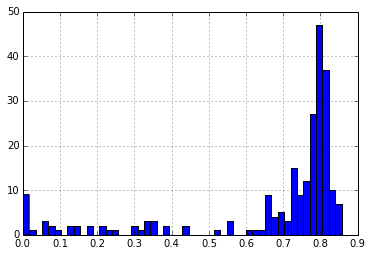

In [93]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('Eel2017_trim30-min90-crop110-forwonly-filter100-deviation0.2_read_stats.csv', index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

Detailed information on what metaBEAT did to each sample is contained in the `log` file. It contains the exact commands that were run for each sample during each step of the process.

In [94]:
!head -n 100 log


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.11-global


Sat Jul  4 02:12:47 2020

/usr/bin/metaBEAT_global.py -Q Querymap_final.txt --trim_qual 30 --read_crop 110 --trim_minlength 90 --merge --product_length 106 --forward_only --length_filter 106 --length_deviation 0.2 -m 12S -o Eel2017_trim30-min90-crop110-forwonly-filter100-deviation0.2 -n 5 -v -@ nathangriffiths484@gmail.com


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'nathangriffiths484@gmail.com'


Parsing querylist file

Number of samples to process: 232
Sequence input format: defaultdict(<type 'int'>, {'fastq': 232})
Barcodes for demultiplexing provided for 0 samples
Cropping instructions provided for 232 samples


Sat Jul  4 02:12:47 2020


##### processing query ID: 24-S1 #####


### R

The next steps in the processing will be chimera detection, and global clustering of the centroids from all clusters from all samples to produce denovo OTUs. The temporary files from the global clustering and the final OTU table were written to the directory `./GLOBAL`.

In [95]:
!ls GLOBAL/

Eel2017_trim30-min90-crop110-forwonly-filter100-deviation0.2-OTU-denovo.biom
Eel2017_trim30-min90-crop110-forwonly-filter100-deviation0.2-OTU-denovo.tsv
global_centroids.fasta
global_queries.fasta
global.uc


The denovo OTU table (numbers are reads) can be viewed to see how OTUs are distributed across your samples. 

# Chimera detection

Some stats on the read counts before/after trimming, merging etc. are summarised for you in `metaBEAT_read_stats.csv`.

Next stage of the processing is chimera detection and removal of putative chimeric sequences. We'll do that using uchime as implemented in vsearch.

In [96]:
!pwd

/home/working/1-trimming


In [97]:
cd ..

/home/working


In [98]:
!mkdir 2-chimera_detection

In [99]:
cd 2-chimera_detection

/home/working/2-chimera_detection


Convert reference database from GenBank to fasta format to be used in chimera detection.

Prepare `REFmap.txt` file, i.e. text file that specifies the location and the format of the reference to be used.
The reference sequences in GenBank format are present in subdirectories for each vertebrate group in the `../Reference_database` directory.

In [106]:
!echo '../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb\tgb\n' \
'../supplementary_data/Reference_DBs/M.zebra.gb\tgb'> REFmap.txt

In [107]:
!echo '../supplementary_data/Reference_DBs/12S_UKmammals_SATIVA_cleaned_June_2018.gb\tgb\n' \
'../supplementary_data/Reference_DBs/12S_UKamphibians_SATIVA_cleaned.gb\tgb\n' \
'../supplementary_data/Reference_DBs/12S_UKreptiles_SATIVA_cleaned.gb\tgb\n' \
'../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb\tgb\n' \
'../supplementary_data/Reference_DBs/12S_UKbirds_SATIVA_cleaned.gb\tgb\n' \
'../supplementary_data/Reference_DBs/M.zebra.gb\tgb'> REFmap.txt

In [108]:
!cat REFmap.txt

../supplementary_data/Reference_DBs/12S_UKmammals_SATIVA_cleaned_June_2018.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKamphibians_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKreptiles_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKbirds_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/M.zebra.gb	gb


In [109]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

In [110]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f \
-@ nathangriffiths484@gmail.com


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.11-global


Sat Jul  4 12:13:54 2020

/usr/bin/metaBEAT_global.py -R REFmap.txt -f -@ nathangriffiths484@gmail.com


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'nathangriffiths484@gmail.com'


######## PROCESSING REFERENCE DATA ########


processing ../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb (containing 340 records)

total number of valid records: 340


processing ../supplementary_data/Reference_DBs/12S_UKbirds_SATIVA_cleaned.gb (containing 622 records)

total number of valid records: 962


processing ../supplementary_data/Reference_DBs/M.zebra.gb (containing 1 records)

total number of valid records: 963


processing ../supplementary_data/Reference_DBs/12S_UKmammals_SATIVA

Traceback (most recent call last):
  File "/usr/bin/metaBEAT_global.py", line 2575, in <module>
    out.write(BIOM_tables_per_method['OTU_denovo'].to_tsv()) #to_json('generaged by test', direct_io=out)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 4027, in to_tsv
    observation_column_name)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 1268, in delimited_self
    raise TableException("Cannot delimit self if I don't have data...")
biom.exception.TableException: Cannot delimit self if I don't have data...


This will produce `refs.fasta`.

In [111]:
!head refs.fasta

>KC292935|7962|Cyprinus carpio
CCAGAAAAGAGAGATTTTAACTCTCACCCCTGGCTCCCAAAGCCAGAATTCTAAACTAAACTATTTTCTGGGGAGGTAGCACTCCCTTTATGGTATAGTACATATTATGCATAATATTACATTAATGTATTAGTACATATATGTATTATCACCAACTCACTATTTTAACCATAAAGCAGGTACATAATATTAAGGTGGGCATAAAGCATATTATTAAGACTCACAAATTCTATTATTTGGACTTGAGTAATATATTAATCCCCAAAAATTTGTCCTCAAATTTTTCCTTGAAATAATCAACTATAATTCCATTTAAACATATTAATGTAGTAAGAGACCACCAACCAGTTTATATAAAGGTATATCATGAATGATAGAATCAAGGACAATAATTGTGAGGGTTACACAATATGAACTATTACTGGCATCTGGTTCCTATTTCAGGGACATAACTGTAATATTCCACCCTCGGATAATTATACTGGCATCTGATTAATGGTGTAAGTACATACGTTTCATTACCCCCCATGCCGAGCATTCTTTTATATGCATAAGGTATTTTTTATTGGTTTCCTTTCATCTGGCATTTCAGAGTGCAGGCTCAAATGTTAAATCAAGGTTGAACATTTTCCTTGTATGTGATAATATATATTAATTATCGTAAGACATAATTTAAGAATTACATACTTTTATCTCAAGTGCATAATATATCTGTCTCTAGTTCAACTTATCCTTACATAGTGCCCCCTTTGGTTTTTGCGCGACAAACCCCCTTACCCCCTACGCTCAGCGAATCCTGTTATCCTTGTCAAACCCCGAAACCAAGGAGGACCCAAGAACGTGTAAACCAACGAGTTGAGGTATAAATTGGCATCCCATTATATATATATATATATATGCATCGGTTTTTTTAACCGCAACTTACCACTTACCTAAAAGCCCCTACCAAAAATCCCCAAAAAGAGGCTC

Now run chimera detection.

In [112]:
%%bash


for a in $(cut -f 1 ../1-trimming/Querymap.txt)
do
    if [ -s ../1-trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../1-trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log 
        cd ..

    else
        echo -e "$a is empty"
    fi
done


### Detecting chimeras in 24-blank ###


### Detecting chimeras in 24-S1 ###


### Detecting chimeras in 24-S2 ###


### Detecting chimeras in 24-S3 ###


### Detecting chimeras in 24-S4 ###


### Detecting chimeras in 24-S5 ###


### Detecting chimeras in 25-blank ###


### Detecting chimeras in 25-S1 ###


### Detecting chimeras in 25-S2 ###


### Detecting chimeras in 25-S3 ###


### Detecting chimeras in 25-S4 ###


### Detecting chimeras in 25-S5 ###


### Detecting chimeras in 26-blank ###


### Detecting chimeras in 26-S1 ###


### Detecting chimeras in 26-S2 ###


### Detecting chimeras in 26-S3 ###


### Detecting chimeras in 26-S4 ###


### Detecting chimeras in 26-S5 ###


### Detecting chimeras in BL3-blank ###


### Detecting chimeras in BL3-S1 ###


### Detecting chimeras in BL3-S2 ###


### Detecting chimeras in BL3-S3 ###

BL3-S4 is empty

### Detecting chimeras in BL3-S5 ###


### Detecting chimeras in BL4-blank ###


### Detecting chimeras in BL4-S1 ###


### Detecti

# Clustering and taxonomic assignment against UK fish database

In [142]:
!pwd

/home/working/4-taxonomic_assignment_vertebrates


In [143]:
cd ..

/home/working


In [144]:
!mkdir 3-taxonomic_assignment_fish

mkdir: cannot create directory ‘3-taxonomic_assignment_fish’: File exists


In [145]:
cd 3-taxonomic_assignment_fish/

/home/working/3-taxonomic_assignment_fish


Produce the text file containing the fish reference sequences using the command line - we call it `REFmap.txt`.

In [146]:
!echo '../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb\tgb\n' \
'../supplementary_data/Reference_DBs/M.zebra.gb\tgb'> REFmap.txt

In [164]:
!cat REFmap.txt

../supplementary_data/Reference_DBs/12S_UKmammals_SATIVA_cleaned_June_2018.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKamphibians_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKreptiles_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
 ../supplementary_data/Reference_DBs/12S_UKbirds_SATIVA_cleaned.gb	gb
 ../supplementary_data/Reference_DBs/M.zebra.gb	gb


Produce the text file containing non-chimera query sequences - `Querymap.txt`.

In [165]:
%%bash

#Querymap
for a in $(ls -l ../2-chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
    echo -e "$a-nc\tfasta\t../2-chimera_detection/$a/$a-nonchimeras.fasta"
done > Querymap.txt

In [166]:
!cat Querymap.txt

24-blank-nc	fasta	../2-chimera_detection/24-blank/24-blank-nonchimeras.fasta
24-S1-nc	fasta	../2-chimera_detection/24-S1/24-S1-nonchimeras.fasta
24-S2-nc	fasta	../2-chimera_detection/24-S2/24-S2-nonchimeras.fasta
24-S3-nc	fasta	../2-chimera_detection/24-S3/24-S3-nonchimeras.fasta
24-S4-nc	fasta	../2-chimera_detection/24-S4/24-S4-nonchimeras.fasta
24-S5-nc	fasta	../2-chimera_detection/24-S5/24-S5-nonchimeras.fasta
25-blank-nc	fasta	../2-chimera_detection/25-blank/25-blank-nonchimeras.fasta
25-S1-nc	fasta	../2-chimera_detection/25-S1/25-S1-nonchimeras.fasta
25-S2-nc	fasta	../2-chimera_detection/25-S2/25-S2-nonchimeras.fasta
25-S3-nc	fasta	../2-chimera_detection/25-S3/25-S3-nonchimeras.fasta
25-S4-nc	fasta	../2-chimera_detection/25-S4/25-S4-nonchimeras.fasta
25-S5-nc	fasta	../2-chimera_detection/25-S5/25-S5-nonchimeras.fasta
26-blank-nc	fasta	../2-chimera_detection/26-blank/26-blank-nonchimeras.fasta
26-S1-nc	fasta	../2-chimera_detection/26-S1/26-S1-nonchimeras.fasta
26-S2-nc	fasta	../2-c

The Querymap.txt file has been made but includes the `./GLOBAL` directory in which all centroids and queries are contained. This will cause metaBEAT to fail so it must be removed manually from the `Querymap.txt` file.

In [167]:
!sed '/GLOBAL/d' Querymap.txt > Querymap_final.txt

In [168]:
!cat Querymap_final.txt

24-blank-nc	fasta	../2-chimera_detection/24-blank/24-blank-nonchimeras.fasta
24-S1-nc	fasta	../2-chimera_detection/24-S1/24-S1-nonchimeras.fasta
24-S2-nc	fasta	../2-chimera_detection/24-S2/24-S2-nonchimeras.fasta
24-S3-nc	fasta	../2-chimera_detection/24-S3/24-S3-nonchimeras.fasta
24-S4-nc	fasta	../2-chimera_detection/24-S4/24-S4-nonchimeras.fasta
24-S5-nc	fasta	../2-chimera_detection/24-S5/24-S5-nonchimeras.fasta
25-blank-nc	fasta	../2-chimera_detection/25-blank/25-blank-nonchimeras.fasta
25-S1-nc	fasta	../2-chimera_detection/25-S1/25-S1-nonchimeras.fasta
25-S2-nc	fasta	../2-chimera_detection/25-S2/25-S2-nonchimeras.fasta
25-S3-nc	fasta	../2-chimera_detection/25-S3/25-S3-nonchimeras.fasta
25-S4-nc	fasta	../2-chimera_detection/25-S4/25-S4-nonchimeras.fasta
25-S5-nc	fasta	../2-chimera_detection/25-S5/25-S5-nonchimeras.fasta
26-blank-nc	fasta	../2-chimera_detection/26-blank/26-blank-nonchimeras.fasta
26-S1-nc	fasta	../2-chimera_detection/26-S1/26-S1-nonchimeras.fasta
26-S2-nc	fasta	../2-c

Update the taxonomy database in the current metaBEAT image.

In [170]:
!taxit new_database \
--taxdump-url ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdump_archive/taxdmp_2018-10-01.zip \
    --download-dir /usr/bin/ /usr/bin/taxonomy.db

That's almost it. Now start the pipeline to do sequence clustering and taxonomic assignment of non-chimera queries via metaBEAT. As input, `Querymap.txt` containing samples that have been trimmed, merged and checked for chimeras, and the `REFmap.txt` file must be specified. metaBEAT will be asked to attempt taxonomic assignment using BLAST.

metaBEAT will automatically wrangle the data into the particular file formats that are required by each of the methods, run all necessary steps, and finally convert the outputs of each program to a standardized BIOM table.

GO!

In [171]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

In [157]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap_final.txt \
-R REFmap.txt \
--cluster --clust_match 1 --clust_cov 3 \
--blast --min_ident 0.98 \
-m 12S -n 5 \
-E -v \
-@ nathangriffiths484@gmail.com \
-o Eel2017_12S-trim30-min90-crop110-mergeforwonly-filt100-dev0.2_nonchimera_c1cov3_blast0.98_fish &> log_fish

echo -e "Endtime: $(date)\n"

Starttime: Sat Jul  4 20:36:09 UTC 2020

Endtime: Sat Jul  4 20:55:40 UTC 2020



In [158]:
!tail -n 50 log_fish

attempting LCA assignment for W20-S1-nc|M04282:74:000000000-BLMMB:1:1108:11991:13655_ex
found LCA 7953 at level family
assigned LCA Cyprinidae (taxid 7953) at level family

attempting LCA assignment for LH-05-nc|M04282:74:000000000-BLMMB:1:1108:9831:20874_ex
found LCA 69291 at level family
assigned LCA Gasterosteidae (taxid 69291) at level family

direct assignment for pos1-nc|M04282:74:000000000-BLMMB:1:1101:15422:9455_ex -> 106582

attempting LCA assignment for 25-S4-nc|M04282:74:000000000-BLMMB:1:1102:26065:10135_ex
found LCA 57865 at level species
assigned LCA Gymnocephalus cernua (taxid 57865) at level species

attempting LCA assignment for W16-S5-nc|M04282:74:000000000-BLMMB:1:1107:23001:16333_ex
found LCA 7953 at level family
assigned LCA Cyprinidae (taxid 7953) at level family

attempting LCA assignment for T-01-nc|M04282:74:000000000-BLMMB:1:1106:19495:16556_ex
found LCA 69291 at level family
assigned LCA Gasterosteidae (taxid 69291) at level family

attempting LCA assignment 

**DONE, Output file under GLOBAL/BLAST_0.98